# Выбор локации для скважины

**Описание задачи**

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**

Данные геологоразведки трёх регионов находятся в файлах:
- `/datasets/geo_data_0.csv`;
- `/datasets/geo_data_1.csv`;
- `/datasets/geo_data_2.csv`.

Признаки:
- 'id' — уникальный идентификатор скважины;
- 'f0', 'f1', 'f2' — три признака точек (неважно, что они означают, но сами признаки значимы);
- 'product' — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

In [1]:
# импорт библиотек

import pandas as pd

import numpy as np
from numpy.random import RandomState

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error

In [2]:
# отключу предупреждения
import warnings
warnings.filterwarnings('ignore')

## Загрузка и подготовка данных

### Обзор данных

#### Регион 0

In [3]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')

In [4]:
# получаю общую сводку
data_0.info()

# проверю на корректный вывод
display(data_0.sample(5))

# проверяю имена колонок на пробелы
display(data_0.columns)

# проверю на явные дубликаты
print(f'Количество явных дубликатов: {data_0.duplicated().sum()}')

# описание
data_0.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
39556,ASPpT,1.309064,-0.577802,0.017004,118.564914
65071,7qs1F,0.041681,0.213124,0.299677,120.408048
71200,ANeYC,0.495188,0.823262,-0.101407,92.379225
36193,VKO0U,0.102607,0.360201,4.571955,184.627078
75902,er4hz,1.377686,-0.381834,11.593748,132.462685


Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')

Количество явных дубликатов: 0


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


Имеется нулевое значение в признаке 'product'.

In [5]:
data_0.query('product == 0').head()

,id,f0,f1,f2,product
57263,zCM5W,-0.702064,0.375992,0.236572,0.0


Всего одна пустая скважина - не окажет влияния на модель. 
Для категориальных данных я бы просто оценил соотношении классов. Так как в данном случае целевой признак это количественные данные то взгляну на распределение количества продукта внутри целевого признака с помощью визуализации.

In [6]:
# задам размер графика
sns.set(rc={'figure.figsize':(20,10)})

<AxesSubplot:xlabel='Volume (thousand barrels)', ylabel='Number of Wells'>

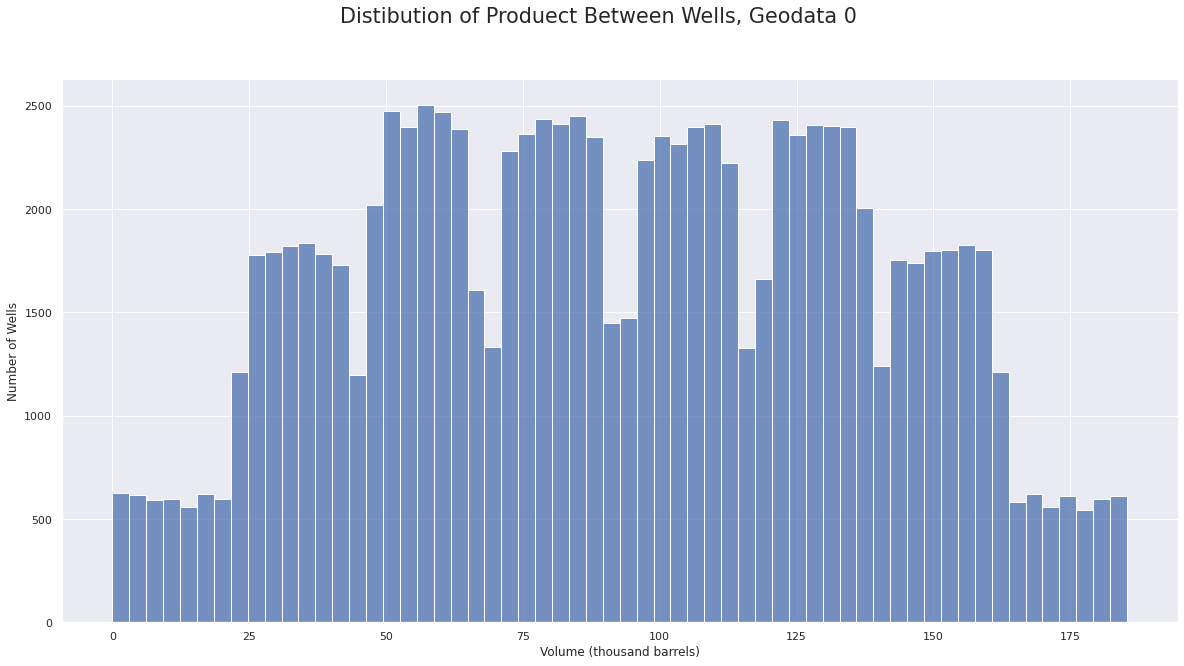

In [7]:
# дам название графику для наглядности
plt.xlabel("Volume (thousand barrels)")
plt.ylabel("Number of Wells")

plt.suptitle('Distibution of Produect Between Wells, Geodata 0 ', size='xx-large')
sns.histplot(data_0['product'])

Несколько пиков, но в целом распредление близко к нормальному.

#### Регион 1

In [8]:
data_1 = pd.read_csv('/datasets/geo_data_1.csv')

In [9]:
# получаю общую сводку
data_1.info()

# проверю на корректный вывод
display(data_1.sample(5))

# проверяю имена колонок на пробелы
display(data_1.columns)

# проверю на явные дубликаты
print(f'Количество явных дубликатов: {data_1.duplicated().sum()}')

# описание
data_1.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
1990,k3ItK,6.882722,-2.568060,1.003313,26.953261
2337,MG4wD,-0.518553,-1.283014,2.994863,80.859783
1159,VdZfJ,1.550666,-2.547108,0.995368,26.953261
50315,XHDzw,-13.558492,-10.131454,3.001778,84.038886
88102,yPyAM,-11.656993,-2.121331,4.006453,110.992147


Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')

Количество явных дубликатов: 0


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


Имеется нулевое значение в признаке 'product'.

In [10]:
data_1.query('product == 0').head()

,id,f0,f1,f2,product
11,OXyvW,16.320755,-0.562946,-0.001783,0.0
13,igmai,6.695604,-0.749449,-0.007630,0.0
62,Qjy5w,21.418478,-5.134490,-0.002836,0.0
63,G6WCj,6.822701,3.104979,-0.000723,0.0
77,MzQhL,6.750150,-11.893512,-0.001601,0.0


In [11]:
data_1.query('product == 0').shape[0]

8235

Большое количество нулевых скважин. Расчет процента не нужен, при 100 000 строк получаем 8.235% "нулевок".

Необходимо оценить распределение объема по скважинам.

<AxesSubplot:xlabel='product', ylabel='Count'>

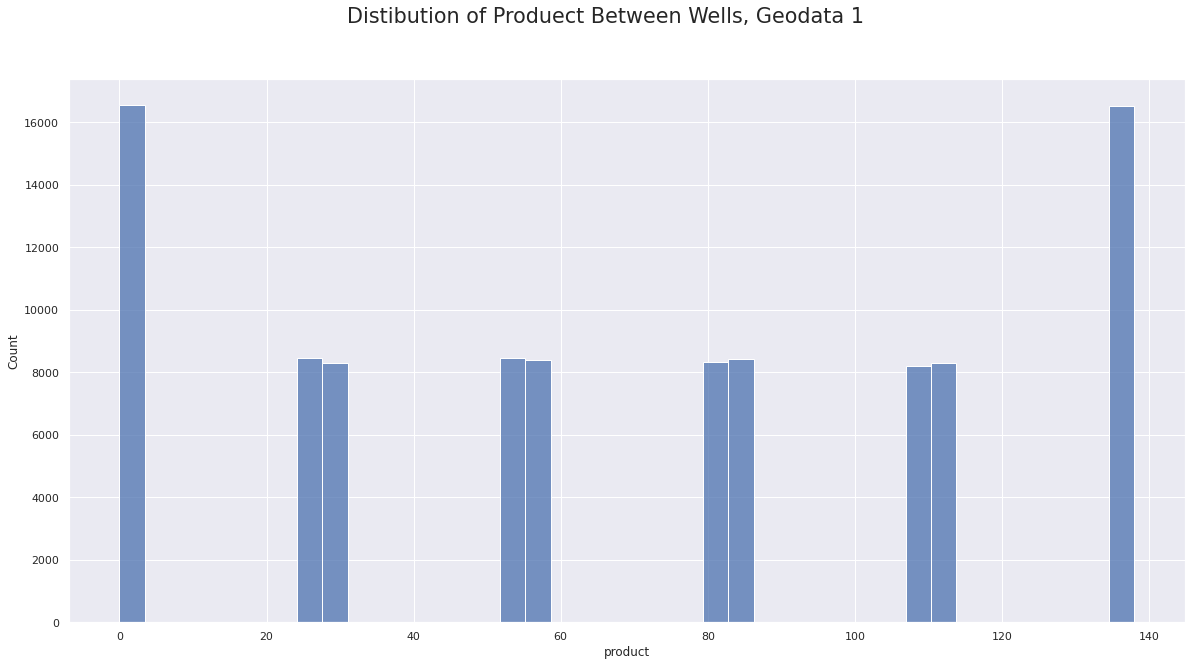

In [12]:
plt.suptitle('Distibution of Produect Between Wells, Geodata 1 ', size='xx-large')
sns.histplot(data_1['product'])

Очень странное распределение. Равномерное, с большим и схожим шагом между значениями. Возможно из-за ошибки работы модели предсказания объемов, либо ошибки выгрузки данных. Либо это искусственный набор данных.

Взгляну на количественное представление каждого из значений целевого признака.

In [13]:
data_1['product'].value_counts()

53.906522     8472
26.953261     8468
84.038886     8431
57.085625     8390
3.179103      8337
80.859783     8320
30.132364     8306
134.766305    8304
110.992147    8303
0.000000      8235
137.945408    8233
107.813044    8201
Name: product, dtype: int64

#### Регион 2

In [14]:
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [15]:
# получаю общую сводку
data_2.info()

# проверю на корректный вывод
display(data_2.sample(5))

# проверяю имена колонок на пробелы
display(data_2.columns)

# проверю на явные дубликаты
print(f'Количество явных дубликатов: {data_2.duplicated().sum()}')

# описание
data_2.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
44501,wawVM,1.784580,-2.277355,2.164149,61.487377
83243,5N39p,-4.545659,-0.278764,2.082688,70.564040
10091,eYXob,-1.315507,1.732310,1.490091,29.412162
2736,SMx78,-1.115599,1.067706,-3.448214,22.946418
86767,BbgDT,0.142421,2.149296,8.237691,169.298071


Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')

Количество явных дубликатов: 0


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


Имеется нулевое значение в признаке 'product'.

In [16]:
data_2.query('product == 0').head()

,id,f0,f1,f2,product
68149,qeefd,-0.865596,-1.615247,-4.126441,0.0


Всего одна нулевая скважина. Оценю распределение.

<AxesSubplot:xlabel='product', ylabel='Count'>

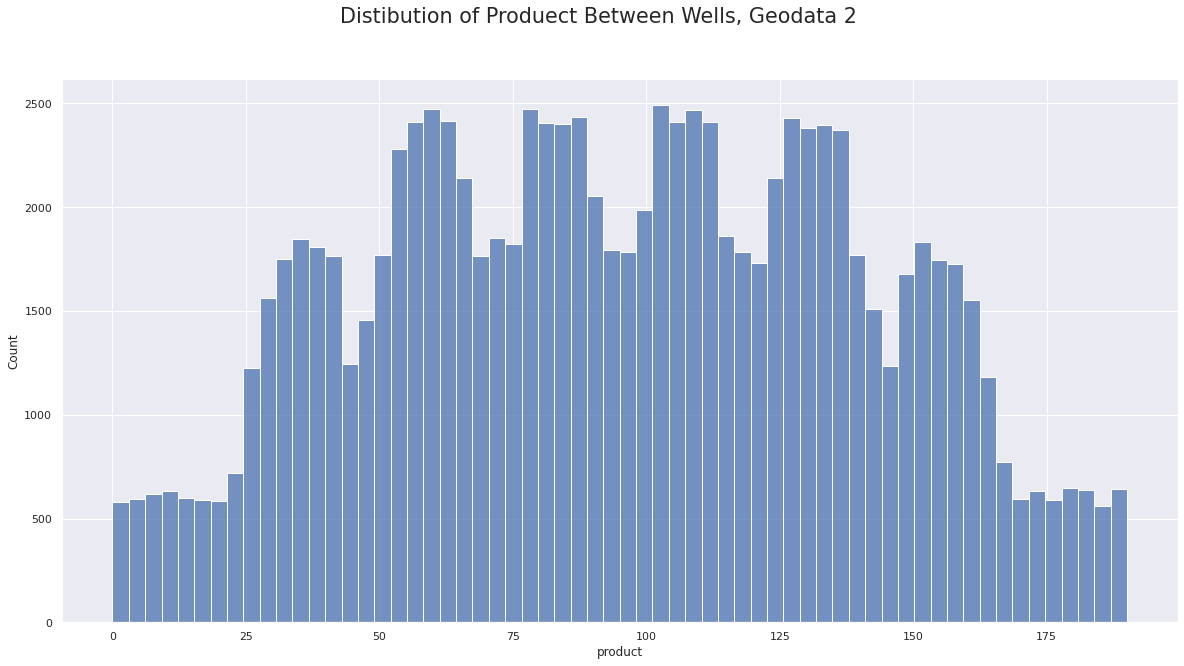

In [17]:
plt.suptitle('Distibution of Produect Between Wells, Geodata 2 ', size='xx-large')
sns.histplot(data_2['product'])

Распределение похоже на регион 0, но с менее выраженными промежуточными пиками.

### Подготовка данных

Предварительные замечания:
- Признак ['id'] не требуется для обучения модели;
- Регион 1 демонстрирует необычное распределение значений в целевом признаке и содержит более 8% нулевых значений.

In [18]:
data = [data_0, data_1, data_2]
for df in data:
    df.drop('id', axis=1, inplace=True)

In [19]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


Кроме исключения признака ['id'] - ппредоставленные данные чисты и не требуют подготовки для работы с алгоритмами машинного обучения.

### Вывод

По итогам предобработки:
- Отброшен не требующийся для обучения моделей признак ['id'].

Чтобы избежать ошибочных выводов, геобходимо уведомить заказчика об особенностях данных региона 1. Так как в даннной ситуации подобной возможности нет, буду работать с ними как с корректными.  
Подготовка данных завершена.

## Обучение и проверка модели

### Подготовка выборок

In [20]:
# создам функцию для разбивки данных на обучающую и валидационную выборки

def data_split(df, target):
    features = df.drop([target], axis=1)
    target = df[target]
    
# для фиксации результата здесь использую число 331958815, полученное генератором случайных чисел    
    features_train, features_valid, target_train, target_valid = train_test_split(
    features,
    target,
    test_size=0.25,
    random_state=331958815)
    
    return features, target, features_train, features_valid, target_train, target_valid

In [21]:
# разобью данные

features_0, target_0, features_train_0, features_valid_0, target_train_0, target_valid_0 = data_split(data_0, 'product')

features_1, target_1, features_train_1, features_valid_1, target_train_1, target_valid_1 = data_split(data_1, 'product')

features_2, target_2, features_train_2, features_valid_2, target_train_2, target_valid_2 = data_split(data_2, 'product')

In [22]:
# проверю

display(features_train_0.head())

target_valid_1.head()

,f0,f1,f2
86162,-0.075890,1.005965,0.577447
86743,0.845381,0.485103,2.746172
91244,-0.033873,0.260755,2.099883
69740,0.240810,-0.066526,-1.500503
70031,0.189928,-0.064951,2.415255


55599    57.085625
77066     0.000000
80117    84.038886
52313    57.085625
45966    80.859783
Name: product, dtype: float64

### Обучение и применение модели

In [23]:
# для целей данного проекта использую модель с гиперпараметрами по умолчанию
model = LinearRegression()

#### Регион 0

In [24]:
model.fit(features_train_0, target_train_0)

LinearRegression()

In [25]:
prediction_0 = model.predict(features_valid_0)

print('Среднее количество предсказанного сырья по региону 0:', prediction_0.mean())
print('Среднее количество сырья валидационной выборки по региону 0:', target_valid_0.mean())
'RMSE прогноза по региону 0:', mean_squared_error(target_valid_0, prediction_0)**0.5

Среднее количество предсказанного сырья по региону 0: 92.50962790104397
Среднее количество сырья валидационной выборки по региону 0: 92.17859190809033


('RMSE прогноза по региону 0:', 37.86102486745513)

<AxesSubplot:ylabel='Count'>

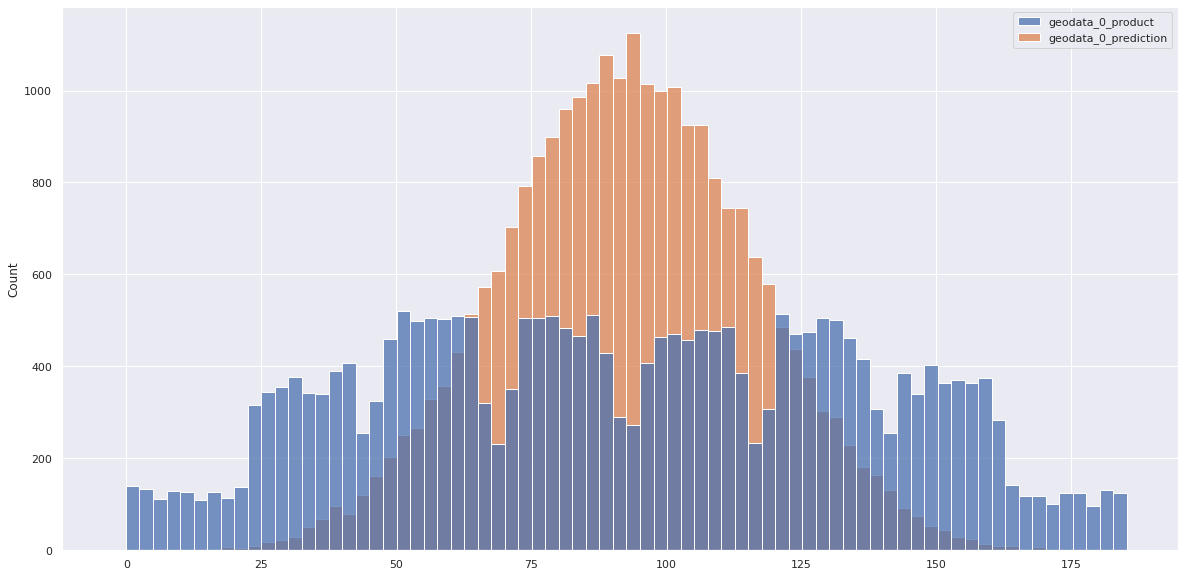

In [26]:
comparison_0 = {'geodata_0_product' : target_valid_0,
            'geodata_0_prediction' : prediction_0}
comparison_0 = pd.DataFrame(comparison_0, columns = ['geodata_0_product', 'geodata_0_prediction'])

sns.histplot(comparison_0)

In [27]:
print('Проверка на адекватность сравнением c RMSE полученным методом кросс-валидации')

accuracies = cross_val_score(estimator=model, X=features_0, y=target_0, scoring='neg_mean_squared_error', cv=5)
abs(accuracies)**0.5

Проверка на адекватность сравнением c RMSE полученным методом кросс-валидации


array([37.87816204, 37.82598584, 37.60116336, 37.47474574, 37.69130564])

#### Регион 1

In [28]:
model.fit(features_train_1, target_train_1)

LinearRegression()

In [29]:
prediction_1 = model.predict(features_valid_1)

print('Среднее количество предсказанного сырья по региону 1:', prediction_1.mean())
print('Среднее количество сырья валидационной выборки по региону 1:', target_valid_1.mean())
'RMSE прогноза по региону 1:', mean_squared_error(target_valid_1, prediction_1)**0.5

Среднее количество предсказанного сырья по региону 1: 68.72076660987298
Среднее количество сырья валидационной выборки по региону 1: 68.7148758865177


('RMSE прогноза по региону 1:', 0.8900512067696233)

<AxesSubplot:ylabel='Count'>

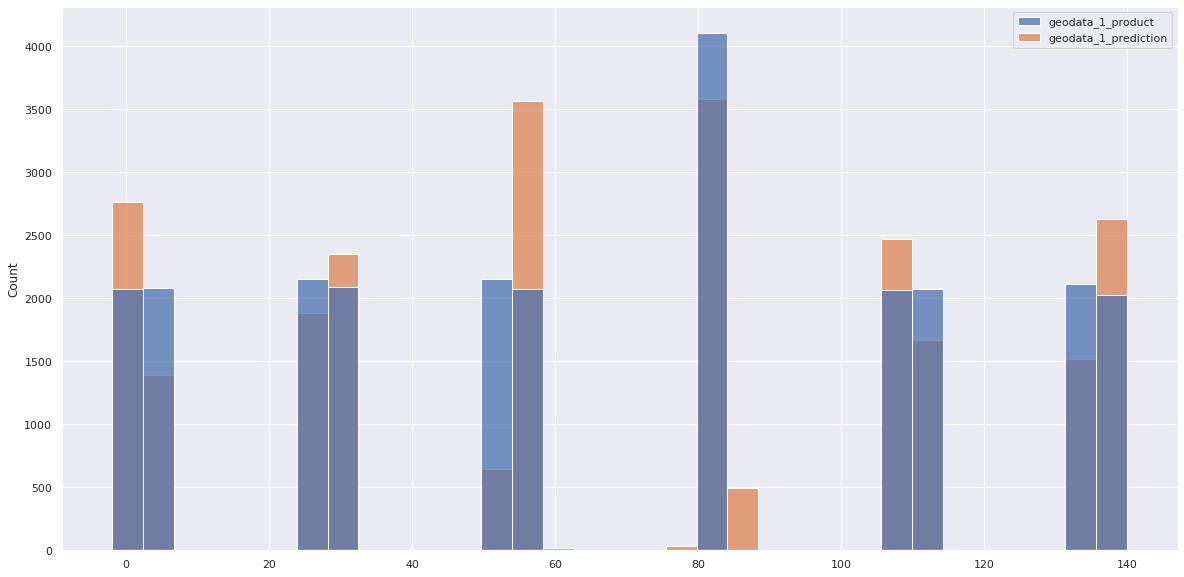

In [30]:
comparison_1 = {'geodata_1_product' : target_valid_1,
            'geodata_1_prediction' : prediction_1}
comparison_1 = pd.DataFrame(comparison_1, columns = ['geodata_1_product', 'geodata_1_prediction'])

sns.histplot(comparison_1)

In [31]:
print('Проверка на адекватность сравнением c RMSE полученным методом кросс-валидации')

accuracies = cross_val_score(estimator=model, X=features_1, y=target_1, scoring='neg_mean_squared_error', cv=5)
abs(accuracies)**0.5

Проверка на адекватность сравнением c RMSE полученным методом кросс-валидации


array([0.88598882, 0.89342077, 0.89355793, 0.88417623, 0.89489574])

#### Регион 2

In [32]:
model.fit(features_train_2, target_train_2)

LinearRegression()

In [33]:
prediction_2 = model.predict(features_valid_2)

print('Среднее количество предсказанного сырья по региону 2:', prediction_2.mean())
print('Среднее количество сырья валидационной выборки по региону 2:', target_valid_2.mean())
'RMSE прогноза по региону 2:', mean_squared_error(target_valid_2, prediction_2)**0.5

Среднее количество предсказанного сырья по региону 2: 94.8789094835073
Среднее количество сырья валидационной выборки по региону 2: 94.98860323084635


('RMSE прогноза по региону 2:', 40.019073503442364)

<AxesSubplot:ylabel='Count'>

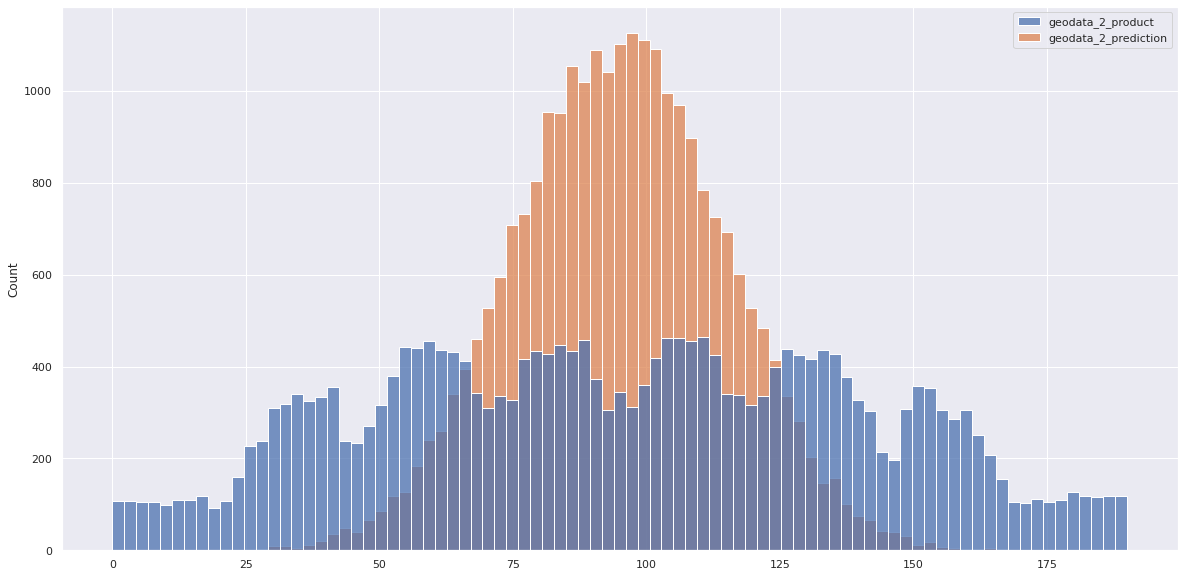

In [34]:
comparison_2 = {'geodata_2_product' : target_valid_2,
            'geodata_2_prediction' : prediction_2}
comparison_2 = pd.DataFrame(comparison_2, columns = ['geodata_2_product', 'geodata_2_prediction'])

sns.histplot(comparison_2)

In [35]:
print('Проверка на адекватность сравнением c RMSE полученным методом кросс-валидации')

accuracies = cross_val_score(estimator=model, X=features_2, y=target_2, scoring='neg_mean_squared_error', cv=5)
abs(accuracies)**0.5

Проверка на адекватность сравнением c RMSE полученным методом кросс-валидации


array([40.36691764, 39.95701048, 40.05694196, 39.91844464, 39.9850842 ])

### Вывод

Наибольшая точность прогноза достигнута по региону 1, с RMSE всего 0.89. Скорее всего высокая точность достигнута путем переобучения модели на однотипных данных региона 1, и модель не пройдет проверку реальностью.

На втором месте по точности прогноза находится регион 0 с RMSE 37.86.

На третьем месте по точности прогноза находится регион 2 c RMSE 40.01.

## Подготовка к расчёту прибыли

### Анализ ключевых значений

Так как объем продукции указан в тысячх баррелей, то вместо увеличения числовых значений предлагаю взять за единицу измерения тысячу рублей.

In [36]:
# сохраню значения ключевые для расчета прибыли в переменных

BUDGET = 10000000 # тыс. р.
PRODUCT_PROFIT = 450 # тыс. р.
WELLS = 500
TOP_WELLS = 200
RISK_THRESHOLD = 0.025

In [37]:
print('Средняя прибыль за точку требуемая для окупаемости бюджета (тыс.р.):')
AVERAGE_PROFIT_REQUIRED = BUDGET / TOP_WELLS

Средняя прибыль за точку требуемая для окупаемости бюджета (тыс.р.):


In [38]:
print('Средний объем продукта на скважину необходимый для окупаемости бюджета (тыс. баррелей):')
AVERAGE_PROFIT_REQUIRED / PRODUCT_PROFIT

Средний объем продукта на скважину необходимый для окупаемости бюджета (тыс. баррелей):


111.11111111111111

In [39]:
print('Количество продукта требуемое для окупаемости бюджета (тыс. баррелей):')
BUDGET / PRODUCT_PROFIT

Количество продукта требуемое для окупаемости бюджета (тыс. баррелей):


22222.222222222223

Рассчитаю средний запас сырья по регионам.

In [40]:
print('Средний запас сырья на скважину в регионе 0:', data_0['product'].mean())

print('Средний запас сырья на скважину в регионе 1:', data_1['product'].mean())

print('Средний запас сырья на скважину в регионе 2:', data_2['product'].mean())

Средний запас сырья на скважину в регионе 0: 92.50000000000001
Средний запас сырья на скважину в регионе 1: 68.82500000000002
Средний запас сырья на скважину в регионе 2: 95.00000000000004


### Расчет прибыли по оптимистичному сценарию

Рассчитаю средний запас сырья в 200 лучших спрогнозированных точках и сравню его со средним запасом в тех же точках по известным данным. В этом расчете я не определяю доверительный интервал и не учитываю RMSE - это оптимистичный прогноз.

In [42]:
display('Средний запас сырья по прогнозу 200 лучших точек региона 0:',
    comparison_0.sort_values(by='geodata_0_prediction', ascending=False).head(TOP_WELLS).mean())

display('Средний запас сырья по прогнозу 200 лучших точек региона 1:',
    comparison_1.sort_values(by='geodata_1_prediction', ascending=False).head(TOP_WELLS).mean())
                  
display('Средний запас сырья по прогнозу 200 лучших точек региона 2:',
    comparison_2.sort_values(by='geodata_2_prediction', ascending=False).head(TOP_WELLS).mean())

'Средний запас сырья по прогнозу 200 лучших точек региона 0:'

geodata_0_product       149.681896
geodata_0_prediction    154.541671
dtype: float64

'Средний запас сырья по прогнозу 200 лучших точек региона 1:'

geodata_1_product       137.945408
geodata_1_prediction    138.760743
dtype: float64

'Средний запас сырья по прогнозу 200 лучших точек региона 2:'

geodata_2_product       137.545539
geodata_2_prediction    148.157181
dtype: float64

Напишу функцию для расчета прибыли и отработаем на ней оптимистичный прогноз.

In [43]:
def profit_calc(data):
    selection = data.sort_values(ascending=False).head(TOP_WELLS)
    total = selection.sum()
    return total * PRODUCT_PROFIT - BUDGET

In [44]:
print('Наилучший сценарий прибыли региона 0:', profit_calc(comparison_0['geodata_0_prediction']).round(2), 'тыс. р.')

Наилучший сценарий прибыли региона 0: 3908750.4 тыс. р.


In [45]:
print('Наилучший сценарий прибыли региона 1:', profit_calc(comparison_1['geodata_1_prediction']).round(2), 'тыс. р.')

Наилучший сценарий прибыли региона 1: 2488466.91 тыс. р.


In [46]:
print('Наилучший сценарий прибыли региона 2:', profit_calc(comparison_2['geodata_2_prediction']).round(2), 'тыс. р.')

Наилучший сценарий прибыли региона 2: 3334146.3 тыс. р.


In [57]:
# видоизменю функцию для расчета реальной прибыли в следующем шаге
# передаю на вход спрогнозированные и реальные значения
# сортирую по убыванию количества сырья в прогнозах и отбираю 200 верхних строк реальных значений
def profit_calc(target, prediction):
    sorted_pred = prediction.sort_values(ascending=False)
    sorted_target = target[sorted_pred.index].head(TOP_WELLS)
    return PRODUCT_PROFIT * sorted_target.sum() - BUDGET

### Вывод

Из анализа ключевых значений видно что отбор скважин необходим для выхода на окупаемость, так как средний объем сырья в регионах значительно ниже среднего объема сырья необходимого даже для компенсации затрат на разработку региона.  
При этом наиболее оптимистичный сценарий показывает прибыльность в размере от 24.8% до 39.1% от вложений.

Пора переходить к расчету прибыли и рисков по реалестичному сценарию.

## Расчёт прибыли и рисков 

`5. Посчитайте риски и прибыль для каждого региона:
5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.`

### Подготовка функции

In [48]:
state = RandomState(331958815)

In [66]:
# передаю на вход спрогнозированные и реальные значения

def realistic_case_profit(target, prediction, bootstrap_samples):
    gains_list=[] # список для хранения значений прибыли
    losses_count = 0 # счетчик количества убыточных случаев
    for i in range(bootstrap_samples):
        preds_subsample = prediction.sample(n=WELLS, replace=True, random_state=state)
        target_subsample = target[preds_subsample.index]
        profit = profit_calc(target_subsample, preds_subsample)
        if profit < 0:
            losses_count +=1
        gains_list.append(profit)
    
    gains_list = pd.Series(gains_list)
    lower = gains_list.quantile(0.025)
    upper = gains_list.quantile(0.975)
    average_profit = gains_list.mean().round(4)
    risk = (losses_count / bootstrap_samples) * 100
    return average_profit, lower, upper, risk

### Регион 0

In [67]:
average_profit_0, lower_0, upper_0, risk_0 = realistic_case_profit(
    comparison_0['geodata_0_product'],
    comparison_0['geodata_0_prediction'],
    1000)

In [68]:
print('Была использована техника бутрстреп на 1000 повторений.')
print(f'Средняя спрогнозированная прибыль по региону 0: {average_profit_0} тыс. р.')
print(f'В 95% доверительном интервале от {lower_0} тыс. р. до {upper_0} тыс. р.')
print(f'Риск убытка в регионе 0 составил {risk_0}%')

Была использована техника бутрстреп на 1000 повторений.
Средняя спрогнозированная прибыль по региону 0: 432828.9681 тыс. р.
В 95% доверительном интервале от -97923.8210730493 тыс. р. до 972269.9333579447 тыс. р.
Риск убытка в регионе 0 составил 5.3%


### Регион 1

In [69]:
average_profit_1, lower_1, upper_1, risk_1 = realistic_case_profit(
    comparison_1['geodata_1_product'],
    comparison_1['geodata_1_prediction'],
    1000)

In [70]:
print('Была использована техника бутрстреп на 1000 повторений.')
print(f'Средняя спрогнозированная прибыль по региону 1: {average_profit_1} тыс. р.')
print(f'В 95% доверительном интервале от {lower_1} тыс. р. до {upper_1} тыс. р.')
print(f'Риск убытка в регионе 0 составил {risk_1}%')

Была использована техника бутрстреп на 1000 повторений.
Средняя спрогнозированная прибыль по региону 1: 497902.2347 тыс. р.
В 95% доверительном интервале от 105180.8229758163 тыс. р. до 960018.0098854995 тыс. р.
Риск убытка в регионе 0 составил 0.6%


### Регион 2

In [71]:
average_profit_2, lower_2, upper_2, risk_2 = realistic_case_profit(
    comparison_2['geodata_2_product'],
    comparison_2['geodata_2_prediction'],
    1000)

In [72]:
print('Была использована техника бутрстреп на 1000 повторений.')
print(f'Средняя спрогнозированная прибыль по региону 2: {average_profit_2} тыс. р.')
print(f'В 95% доверительном интервале от {lower_2} тыс. р. до {upper_2} тыс. р.')
print(f'Риск убытка в регионе 0 составил {risk_2}%')

Была использована техника бутрстреп на 1000 повторений.
Средняя спрогнозированная прибыль по региону 2: 398332.0186 тыс. р.
В 95% доверительном интервале от -113869.58470223051 тыс. р. до 918873.5813327371 тыс. р.
Риск убытка в регионе 0 составил 7.000000000000001%


### Вывод

По итогам прогнозирования прибыльности и рисков по реалистичному сценарию путем использования техники бутстреп с 1000 повторений:
- Регион 0 не соответствует требованиям заказчика, так как риск убытка превышает 2.5% и составляет 5.3%;
- Регион 1 соответствует требованиям заказчика, демонстрирует наибольшую потенциальную прибыль и риск убытков менее 2.5%, составляющий 0.6%;
- Регион 2 не соответствует требованиям заказчика, так как риск убытка превышает 2.5% и составляет 7%;

## Общий вывод

По итогам проекта произведен анализ данных трех регионов с целью определения прибыльности и рисков добычи нефти.  
Из трех регионов отобран один, соответствующий требованиям заказчика.  

Прогнозирование показало потенциальную прибыльность добычи сырья в регионе 1 на уровне 497902.2347 тыс. р., при положительном нижнем пороге доверительного интервала и риске убыточности 0.6%.  
При этом следует уведомить заказчика об аномальном представлении данных по региону.

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован